In [20]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
source("../../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

SVM is used as an intermediary because it comes from python and then it is integrated to each feature usage datasets.

In [198]:
SVM <- read.table("prognosis_tsv/SVM_different_features_type.csv",sep=',',header=T)
list_models <- list.files('prognosis_tsv')[list.files('prognosis_tsv')!="SVM_different_features_type.csv"]
df_w_all <-NULL
for (l in list_models){
  tmp <- cbind(read.table(paste("prognosis_tsv",l,sep="/")),SVM_optimized=SVM[,substr(l,1,nchar(l)-4)])    
  tmp$model <- substr(l,1,nchar(l)-4)
  assign(substr(l,1,nchar(l)-4),melt(tmp,id='model')) 
  df_w_all <- rbind(df_w_all,get(substr(l,1,nchar(l)-4)))
}

colnames(df_w_all) <- c('model','algorithm','CI_test')
model_medians<-c()
df_w_all$model<-factor(df_w_all$model,levels=substr(list_models,1,nchar(list_models)-4))
for( model in levels(df_w_all$model)){

   model_medians <- c(model_medians,median(df_w_all$CI_test[df_w_all$model==as.character(model)]))
}
model_medians<-data.frame(model=levels(df_w_all$model),Z=model_medians)


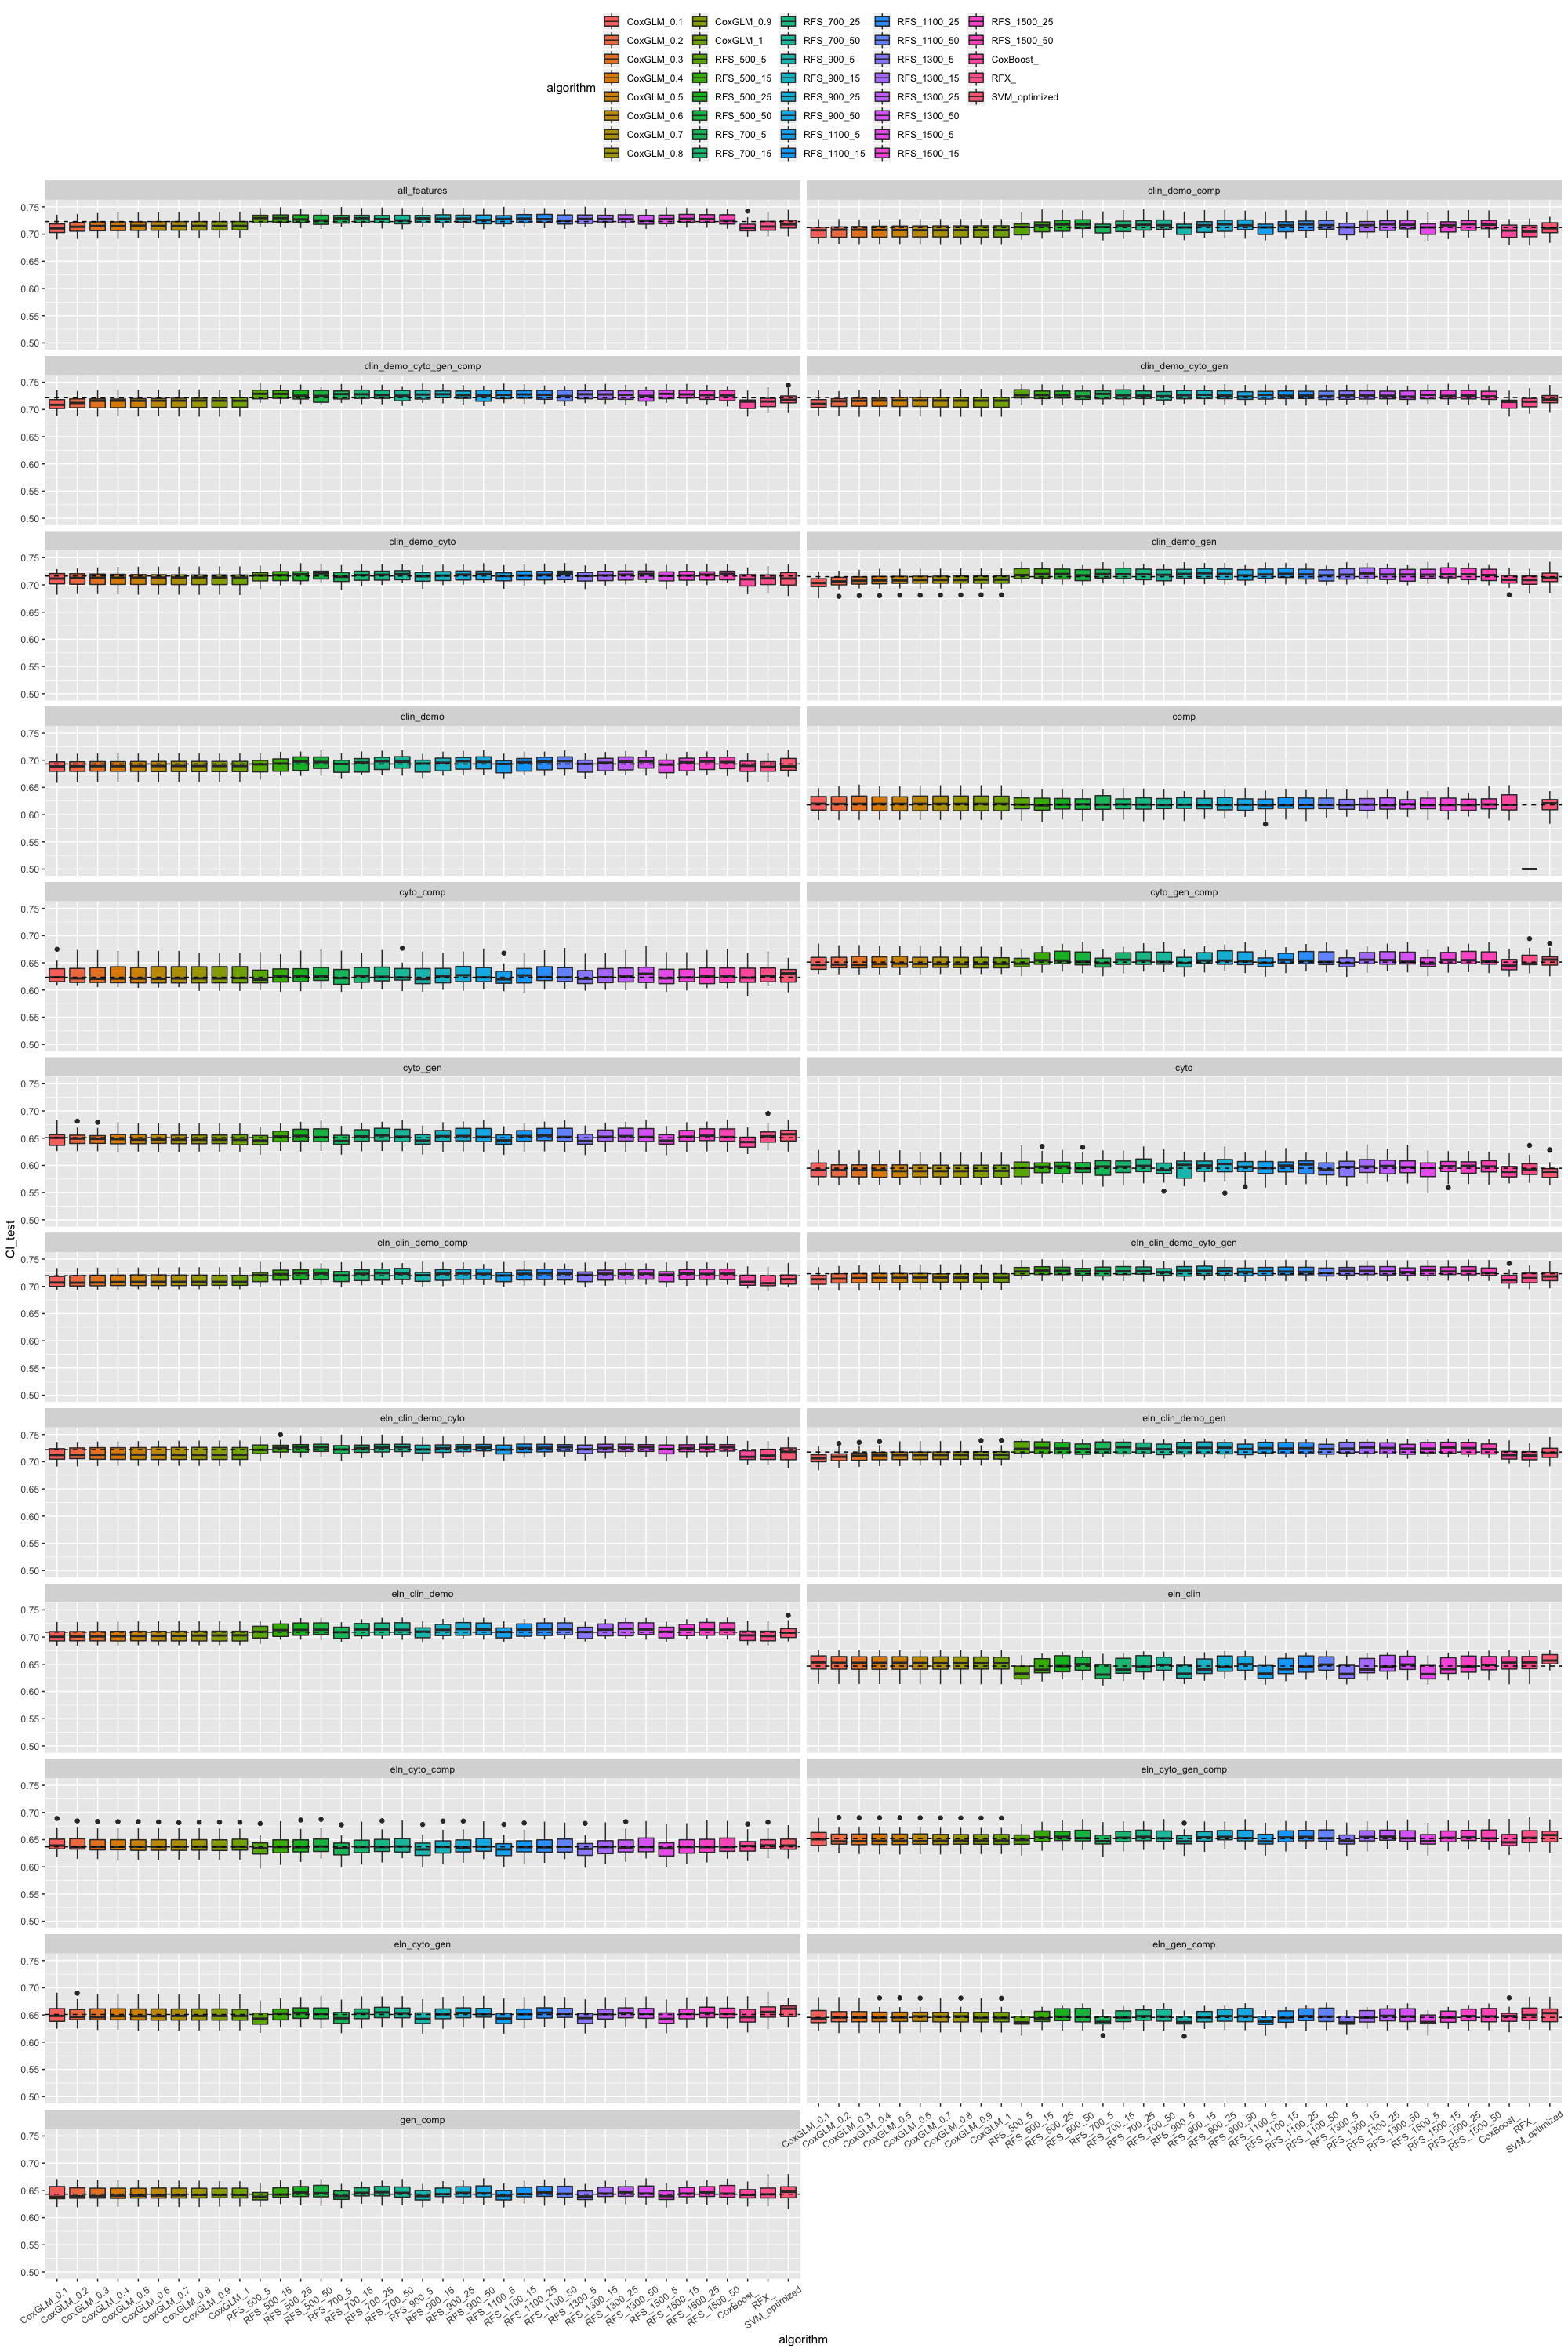

In [199]:
set_notebook_plot_size(20,30)
ggplot(df_w_all,aes(x=algorithm,y=CI_test)) +
    geom_boxplot(aes(fill = algorithm), notch=F)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    facet_wrap( ~ model, ncol=2) +
    geom_hline(data = model_medians, aes(yintercept = Z), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

In [200]:
#nrow = number of prognosis models 
#ncol = number of feature models
table_res <- as.data.frame(matrix(0,nrow =37, ncol=23))
colnames(table_res)<-levels(df_w_all$model)
rownames(table_res)<-levels(df_w_all$algorithm)

for(model in colnames(table_res)){
    for(algo in rownames(table_res)){
        table_res[algo,model]<-median(df_w_all$CI_test[df_w_all$model==model & df_w_all$algorithm==algo])
    }
}
row_names <-rownames(table_res)
table_res$algo<-rownames(table_res)
rownames(table_res)<-NULL
table_res<-melt(table_res,id='algo')
colnames(table_res)<-c('algo','model','CI_test')
table_res$algo<-factor(table_res$algo,levels=row_names)
table_res$model<-factor(table_res$model)

  all_features    clin_demo_comp   clin_demo_cyto_gen_comp clin_demo_cyto_gen
 Min.   :0.7106   Min.   :0.7047   Min.   :0.7085          Min.   :0.7103    
 1st Qu.:0.7150   1st Qu.:0.7075   1st Qu.:0.7162          1st Qu.:0.7164    
 Median :0.7260   Median :0.7131   Median :0.7256          Median :0.7246    
 Mean   :0.7229   Mean   :0.7129   Mean   :0.7228          Mean   :0.7221    
 3rd Qu.:0.7279   3rd Qu.:0.7166   3rd Qu.:0.7277          3rd Qu.:0.7258    
 Max.   :0.7294   Max.   :0.7183   Max.   :0.7288          Max.   :0.7287    
 clin_demo_cyto   clin_demo_gen      clin_demo           comp       
 Min.   :0.7103   Min.   :0.7034   Min.   :0.6879   Min.   :0.5000  
 1st Qu.:0.7132   1st Qu.:0.7093   1st Qu.:0.6892   1st Qu.:0.6178  
 Median :0.7170   Median :0.7185   Median :0.6938   Median :0.6186  
 Mean   :0.7162   Mean   :0.7155   Mean   :0.6935   Mean   :0.6156  
 3rd Qu.:0.7188   3rd Qu.:0.7194   3rd Qu.:0.6970   3rd Qu.:0.6201  
 Max.   :0.7211   Max.   :0.7213   Max. 

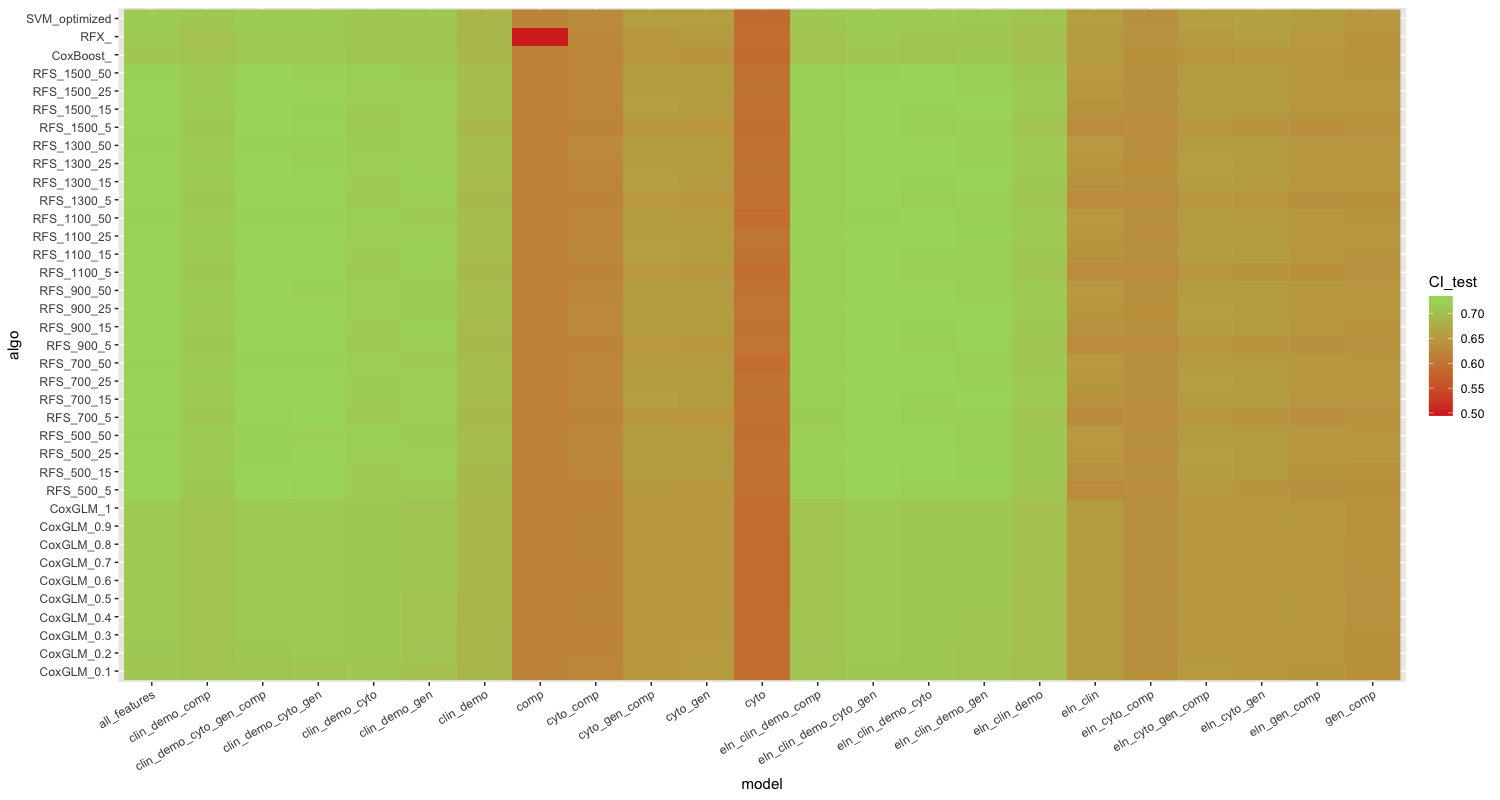

In [201]:
set_notebook_plot_size(15,8)
ggplot(table_res, aes(model, algo)) +

    # geom raster heatmap
    geom_raster(aes(fill = CI_test), show.legend = TRUE) +
    scale_fill_gradient(low="#d73027", high="#a6d96a") +
    tilt_x_label(30) 

In [ ]:
SVM <- read.table("prognosis_tsv/SVM_different_features_type.csv",sep=',',header=T)
all_features <- cbind(read.table("prognosis_tsv/all_features.tsv"),SVM_optimized=SVM$all_features)
all_features$model <- "all_features"
all_features <- melt(all_features,id='model')


clin_demo_comp <- cbind(read.table("prognosis_tsv/clin_demo_comp.tsv"),SVM_optimized=SVM$clin_demo_comp)
clin_demo_comp$model <- "clin_demo_comp"
clin_demo_comp <- melt(clin_demo_comp,id='model')

#
clin_demo_cyto_gen_comp <- cbind(read.table("prognosis_tsv/clin_demo_cyto_gen_comp.tsv"),SVM_optimized=SVM$clin_demo_cyto_gen_comp)
clin_demo_cyto_gen <- cbind(read.table("prognosis_tsv/clin_demo_cyto_gen.tsv"),SVM_optimized=SVM$clin_demo_cyto_gen)
clin_demo_cyto <- cbind(read.table("prognosis_tsv/clin_demo_cyto.tsv"),SVM_optimized=SVM$clin_demo_cyto)
clin_demo_gen <- cbind(read.table("prognosis_tsv/clin_demo_gen.tsv"),SVM_optimized=SVM$clin_demo_gen)
clin_demo <- cbind(read.table("prognosis_tsv/clin_demo.tsv"),SVM_optimized=SVM$clin_demo)
comp <- cbind(read.table("prognosis_tsv/comp.tsv"),SVM_optimized=SVM$comp)
cyto_comp <- cbind(read.table("prognosis_tsv/cyto_comp.tsv"),SVM_optimized=SVM$cyto_comp)
cyto_gen_comp <- cbind(read.table("prognosis_tsv/cyto_gen_comp.tsv"),SVM_optimized=SVM$cyto_gen_comp)
cyto_gen <- cbind(read.table("prognosis_tsv/cyto_gen.tsv"),SVM_optimized=SVM$cyto_gen)
cyto <- cbind(read.table("prognosis_tsv/cyto.tsv"),SVM_optimized=SVM$cyto)
eln_clin_demo_comp <- cbind(read.table("prognosis_tsv/eln_clin_demo_comp.tsv"),SVM_optimized=SVM$eln_clin_demo_comp)
eln_clin_demo_cyto_gen <- cbind(read.table("prognosis_tsv/eln_clin_demo_cyto_gen.tsv"),SVM_optimized=SVM$eln_clin_demo_cyto_gen)
eln_clin_demo_cyto <- cbind(read.table("prognosis_tsv/eln_clin_demo_cyto.tsv"),SVM_optimized=SVM$eln_clin_demo_cyto)
eln_clin_demo_gen <- cbind(read.table("prognosis_tsv/eln_clin_demo_gen.tsv"),SVM_optimized=SVM$eln_clin_demo_gen)
eln_clin_demo <- cbind(read.table("prognosis_tsv/eln_clin_demo.tsv"),SVM_optimized=SVM$eln_clin_demo)
eln_clin <- cbind(read.table("prognosis_tsv/eln_clin.tsv"),SVM_optimized=SVM$eln_clin)
eln_cyto_comp <- cbind(read.table("prognosis_tsv/eln_cyto_comp.tsv"),SVM_optimized=SVM$eln_cyto_comp)
eln_cyto_gen_comp <- cbind(read.table("prognosis_tsv/eln_cyto_gen_comp.tsv"),SVM_optimized=SVM$eln_cyto_gen_comp)
eln_cyto_gen <- cbind(read.table("prognosis_tsv/eln_cyto_gen.tsv"),SVM_optimized=SVM$eln_cyto_gen)
eln_gen_comp <- cbind(read.table("prognosis_tsv/eln_gen_comp.tsv"),SVM_optimized=SVM$eln_gen_comp)
gen_comp <- cbind(read.table("prognosis_tsv/gen_comp.tsv"),SVM_optimized=SVM$gen_comp)




In [22]:
all_features <- melt(all_features,id='model')
eln_clin <- melt(eln_clin,id='model')
eln_clin_demo <- melt(eln_clin_demo,id='model')
eln_clin_demo_cyto <- melt(eln_clin_demo_cyto,id='model')
clin_demo <- melt(clin_demo,id='model') 
cyto_comp <- melt(cyto_comp,id='model') 
eln_clin_demo_cyto_gen <- melt(eln_clin_demo_cyto_gen,id='model')
eln_clin_demo_gen <- melt(eln_clin_demo_gen,id='model')
eln_gen_comp <- melt(eln_gen_comp,id='model')
eln_clin_demo_comp <- melt(eln_clin_demo_comp,id='model')
clin_demo_cyto <- melt(clin_demo_cyto,id='model')
gen_comp <- melt(gen_comp,id='model')

In [23]:
df_w_all <- rbind(
    all_features,
    eln_clin,
    eln_clin_demo,
    eln_clin_demo_cyto,
    clin_demo,
    cyto_comp,
    eln_clin_demo_cyto_gen,
    eln_clin_demo_gen,
    eln_gen_comp,
    eln_clin_demo_comp,
    clin_demo_cyto,
    gen_comp
)
colnames(df_w_all) <- c('model','algorithm','CI_test')

In [24]:
model_medians<-c()
df_w_all$model<-factor(df_w_all$model,levels=c('all_features','eln_clin','eln_clin_demo','eln_clin_demo_cyto',"clin_demo","cyto_comp",
                                               "eln_clin_demo_cyto_gen","eln_clin_demo_gen","eln_gen_comp","eln_clin_demo_comp","clin_demo_cyto","gen_comp"))
for( model in levels(df_w_all$model)){

    model_medians <- c(model_medians,median(df_w_all$CI_test[df_w_all$model==as.character(model)]))
}
model_medians<-data.frame(model=levels(df_w_all$model),Z=model_medians)

In [ ]:
set_notebook_plot_size(20,20)
ggplot(df_w_all,aes(x=algorithm,y=CI_test)) +
    geom_boxplot(aes(fill = algorithm), notch=T)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    facet_wrap( ~ model, ncol=2) +
    geom_hline(data = model_medians, aes(yintercept = Z), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

In [26]:
#nrow = number of prognosis models 
#ncol = number of feature models
table_res <- as.data.frame(matrix(0,nrow =37, ncol=12))
colnames(table_res)<-levels(df_w_all$model)
rownames(table_res)<-levels(df_w_all$algorithm)

for(model in colnames(table_res)){
    for(algo in rownames(table_res)){
        table_res[algo,model]<-median(df_w_all$CI_test[df_w_all$model==model & df_w_all$algorithm==algo])
    }
}
summary(table_res)

  all_features       eln_clin      eln_clin_demo    eln_clin_demo_cyto
 Min.   :0.7106   Min.   :0.6310   Min.   :0.7006   Min.   :0.7089    
 1st Qu.:0.7150   1st Qu.:0.6404   1st Qu.:0.7029   1st Qu.:0.7130    
 Median :0.7260   Median :0.6491   Median :0.7100   Median :0.7230    
 Mean   :0.7229   Mean   :0.6459   Mean   :0.7092   Mean   :0.7206    
 3rd Qu.:0.7279   3rd Qu.:0.6520   3rd Qu.:0.7138   3rd Qu.:0.7258    
 Max.   :0.7294   Max.   :0.6569   Max.   :0.7152   Max.   :0.7265    
   clin_demo        cyto_comp      eln_clin_demo_cyto_gen eln_clin_demo_gen
 Min.   :0.6879   Min.   :0.6191   Min.   :0.7115         Min.   :0.7062   
 1st Qu.:0.6892   1st Qu.:0.6212   1st Qu.:0.7161         1st Qu.:0.7124   
 Median :0.6938   Median :0.6232   Median :0.7266         Median :0.7232   
 Mean   :0.6935   Mean   :0.6234   Mean   :0.7232         Mean   :0.7199   
 3rd Qu.:0.6970   3rd Qu.:0.6253   3rd Qu.:0.7280         3rd Qu.:0.7248   
 Max.   :0.6982   Max.   :0.6306   Max.   :0.72

In [27]:
row_names <-rownames(table_res)
table_res$algo<-rownames(table_res)
rownames(table_res)<-NULL
table_res<-melt(table_res,id='algo')
colnames(table_res)<-c('algo','model','CI_test')
table_res$algo<-factor(table_res$algo,levels=row_names)
table_res$model<-factor(table_res$model)

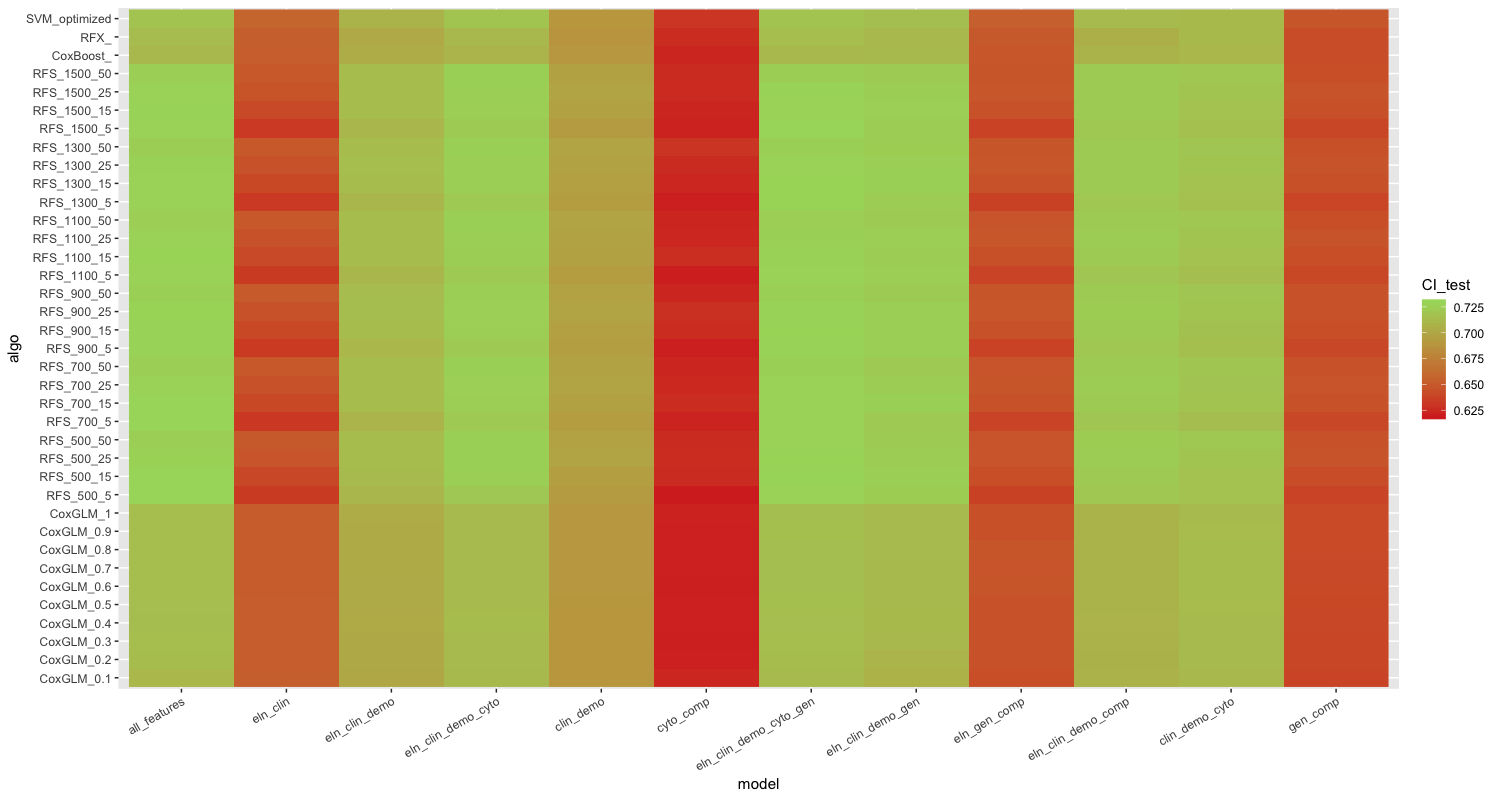

In [28]:
set_notebook_plot_size(15,8)
ggplot(table_res, aes(model, algo)) +

    # geom raster heatmap
    geom_raster(aes(fill = CI_test), show.legend = TRUE) +
    scale_fill_gradient(low="#d73027", high="#a6d96a") +
    tilt_x_label(30) 

# Evaluation of feature importance for different models 

In [10]:
df_final <- read.table("df_prognosis_features_ready.tsv",sep = '\t' , header = T)
### Features that we can use
all_features <- c(1:177)
eln_clin<-c(1,169:175)
eln_clin_demo<-c(1,169:177)
eln_clin_demo_cyto <-c(1,85:153,169:177)
eln_clin_demo_gen <-c(1:84,169:177)
eln_clin_demo_cyto_gen <-c(1:153,169:177)
eln_clin_demo_comp <-c(1,154:177)
eln_cyto_gen<-c(1:153)
eln_cyto_gen_comp <-c(1:168)
eln_cyto_comp <-c(1,85:168)
eln_gen_comp <-c(1:84,154:168)

clin_demo<-c(169:177)
clin_demo_cyto <-c(85:153,169:177)
clin_demo_gen <-c(2:84,169:177)
clin_demo_cyto_gen <-c(2:153,169:177)
clin_demo_comp <-c(154:177)
cyto_gen<-c(2:153)
cyto_gen_comp <-c(2:168)
cyto_comp <-c(85:168)
gen_comp <-c(2:84,154:168)
clin_demo_cyto_gen_comp<-c(2:177)
gen<-c(2:84)
cyto<-c(85:153)
comp<-c(154:168)
###
x <- data.matrix(df_final)
y <- data.matrix(df_final[,c("os","os_status")])

colnames(y) = c("time","status")
response=y
design=x[,all_features]
nrepeats=5
nfolds=5
set.seed(17)
# Make folds

n = nrow(design)
folds <- list()
for (i in seq(nrepeats)) {
    folds <- c(folds,split(sample(seq(n)), rep(1:nfolds, length = n)))
}
nexp = length(folds) # the total number CV of experiments


# I- Cox Models with Penalization

In [11]:
# Chose features you want with design
design=x[,all_features]
# Parallel CV
print("start CV")
rescv = mclapply(seq(nexp),
               FUN=function(iexp) {
                   set.seed(17)
                   cat(".")
                   vTrain = design[-folds[[iexp]],,drop=F]
                   vTest = design[folds[[iexp]],,drop=F]
                   lTrain = response[-folds[[iexp]],]
                   lTest = response[folds[[iexp]],]
                   # Train and Predict
                   cvfit = cv.glmnet(vTrain, lTrain, family="cox", alpha=0.1, nfolds=10, grouped=TRUE)
                   risk.predict = predict(cvfit, newx=vTest, s="lambda.min", type="response")
                   risk.predict = as.vector(risk.predict[,1])
                   ci.test = suppressWarnings(survConcordance(Surv(time,status) ~ risk.predict, as.data.frame(lTest)))
                   # Evaluate CI on the test
                   #return(as.vector(coef(cvfit,s="lambda.min")))
                   return(list(as.matrix(coef(cvfit,s="lambda.min")),as.vector(ci.test$concordance)))  ## return a list with dataframe for variable importance and concordance index of the exp
               },
               mc.cores=25
               )


[1] "start CV"


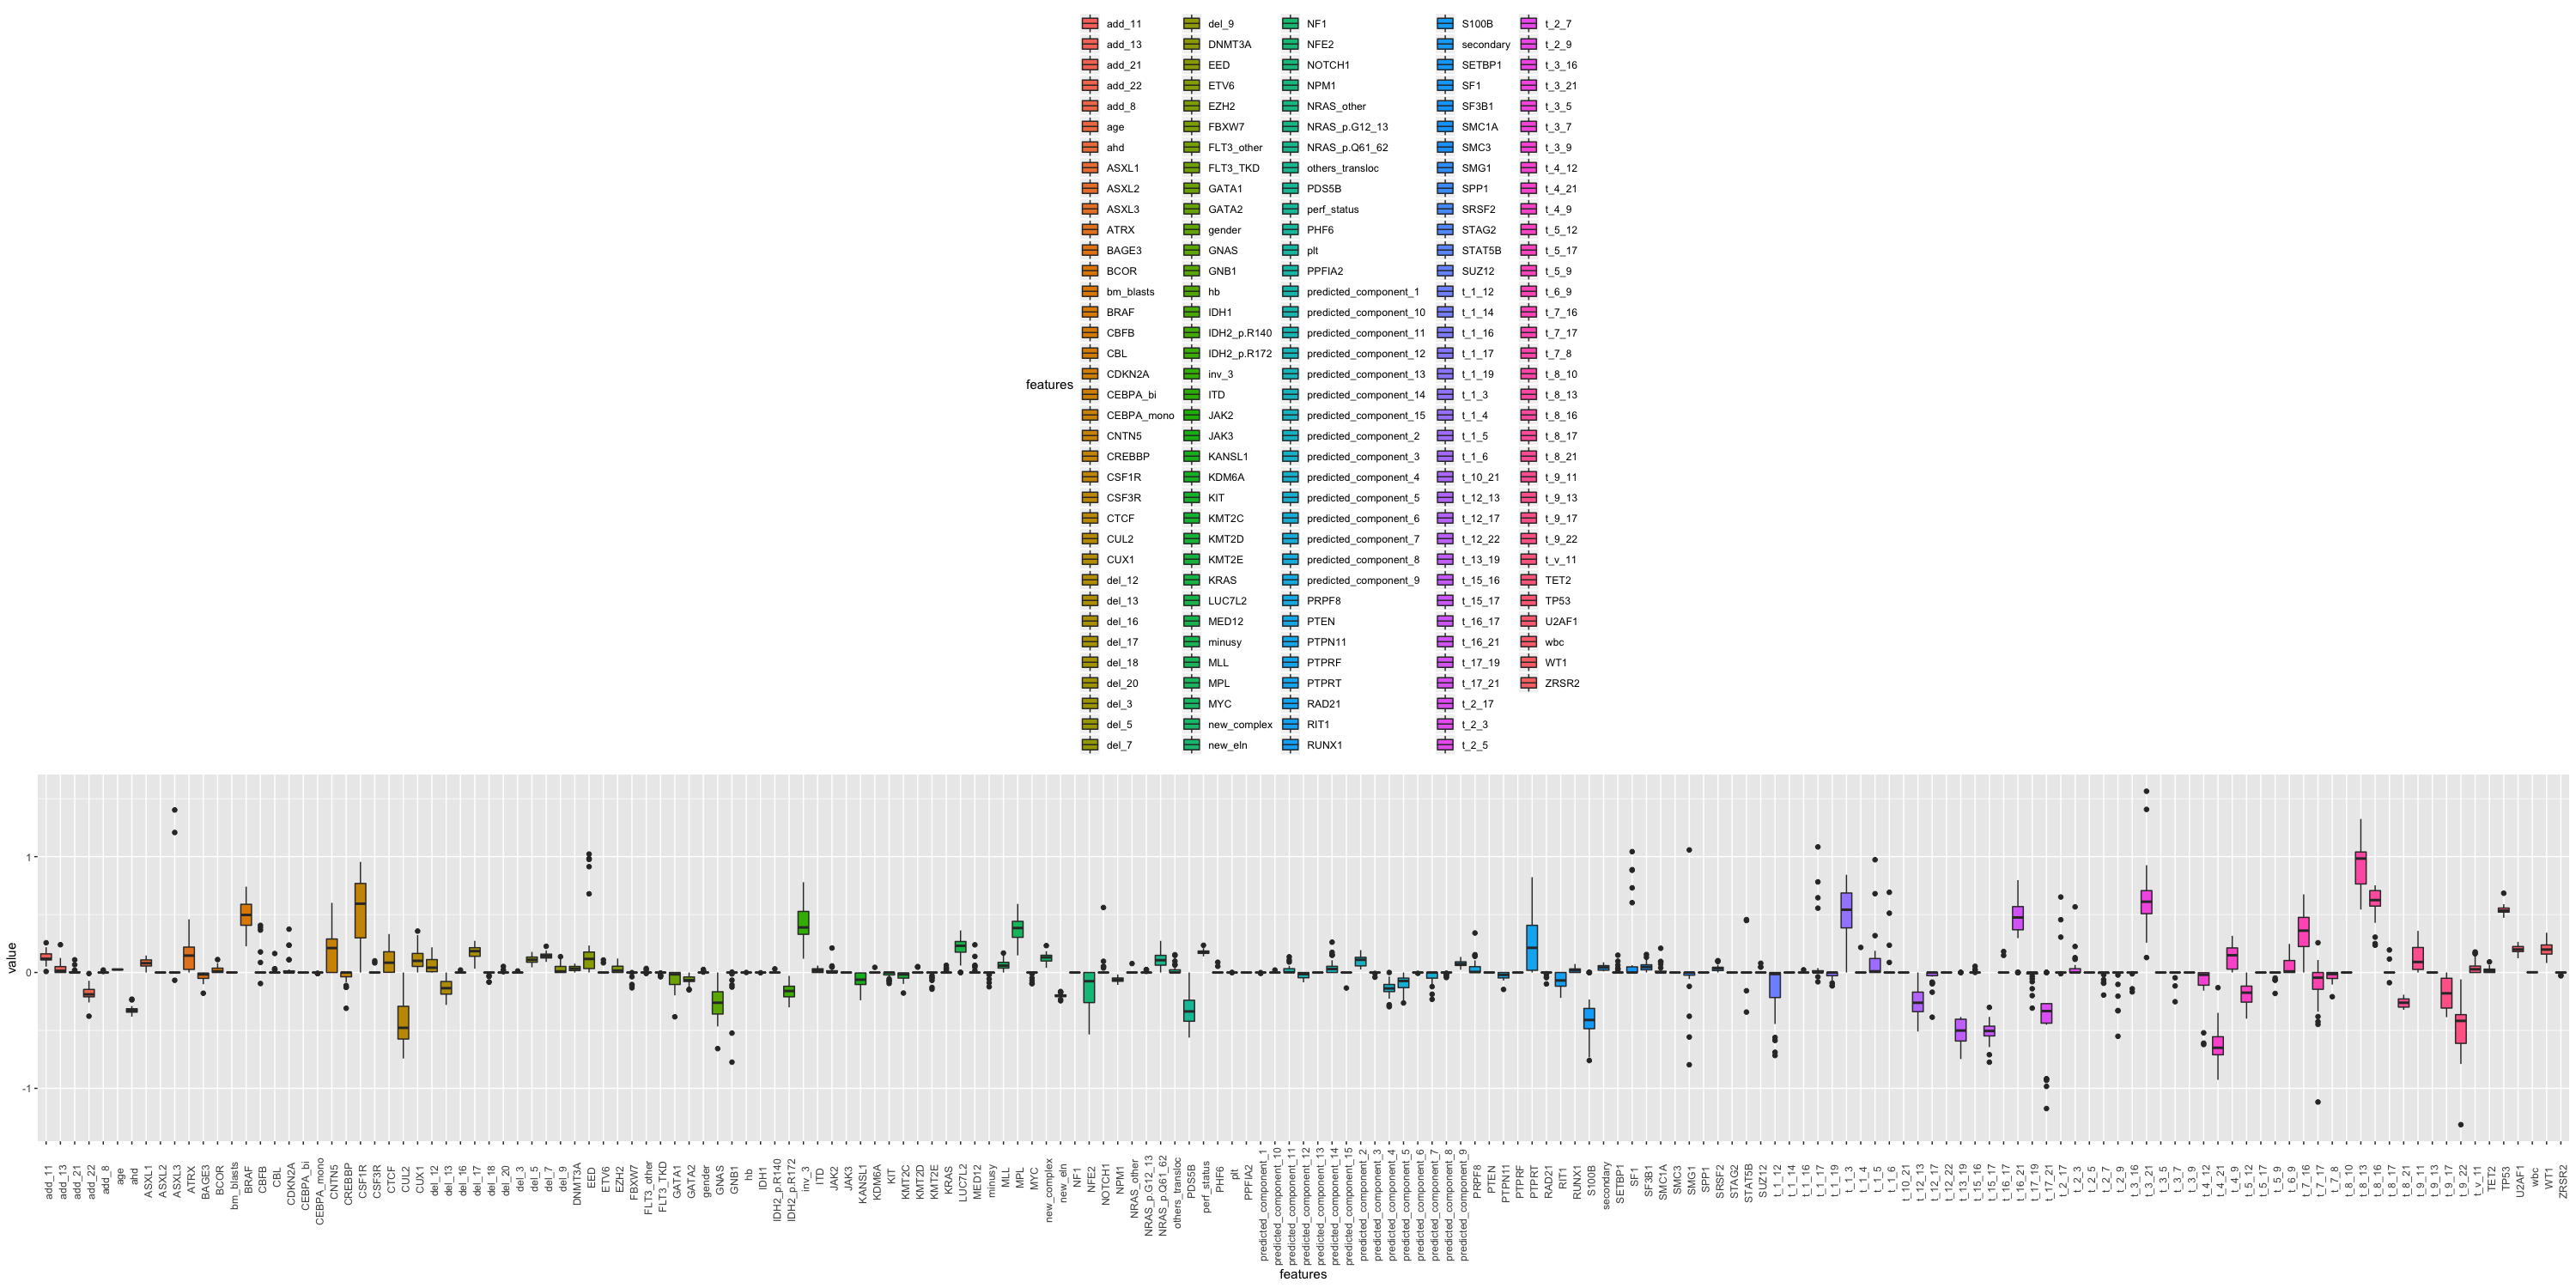

In [12]:
### rescv returns a list with 25 dataframes with the coefficient of each variables for the model cross validated fitted model and 25 concordance indices on the testings set used . We do the boxplots of the variable
### importance to have an exhaustive view over the same algorithm trained differently.
tmp <- rescv[[1]][[1]]
colnames(tmp)[1] <- "exp_1"
for (i in 2:length(rescv)){
    tmp <-cbind(tmp,rescv[[i]][[1]])
    colnames(tmp)[i] <- paste("exp",i,sep="_")
}
tmp <-as.data.frame(tmp)
tmp$median <- apply(tmp,1, median, na.rm = TRUE)
tmp$features <-rownames(tmp)
b <-melt(tmp,id='features')
colnames(b) <- c('features','exp','value')
set_notebook_plot_size(30,15)
ggplot(b,aes(x=features,y=value)) +
    geom_boxplot(aes(fill = features), notch=F)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    #facet_wrap( ~ model, ncol=2) +
    #geom_hline(data = model_medians, aes(yintercept = Z), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

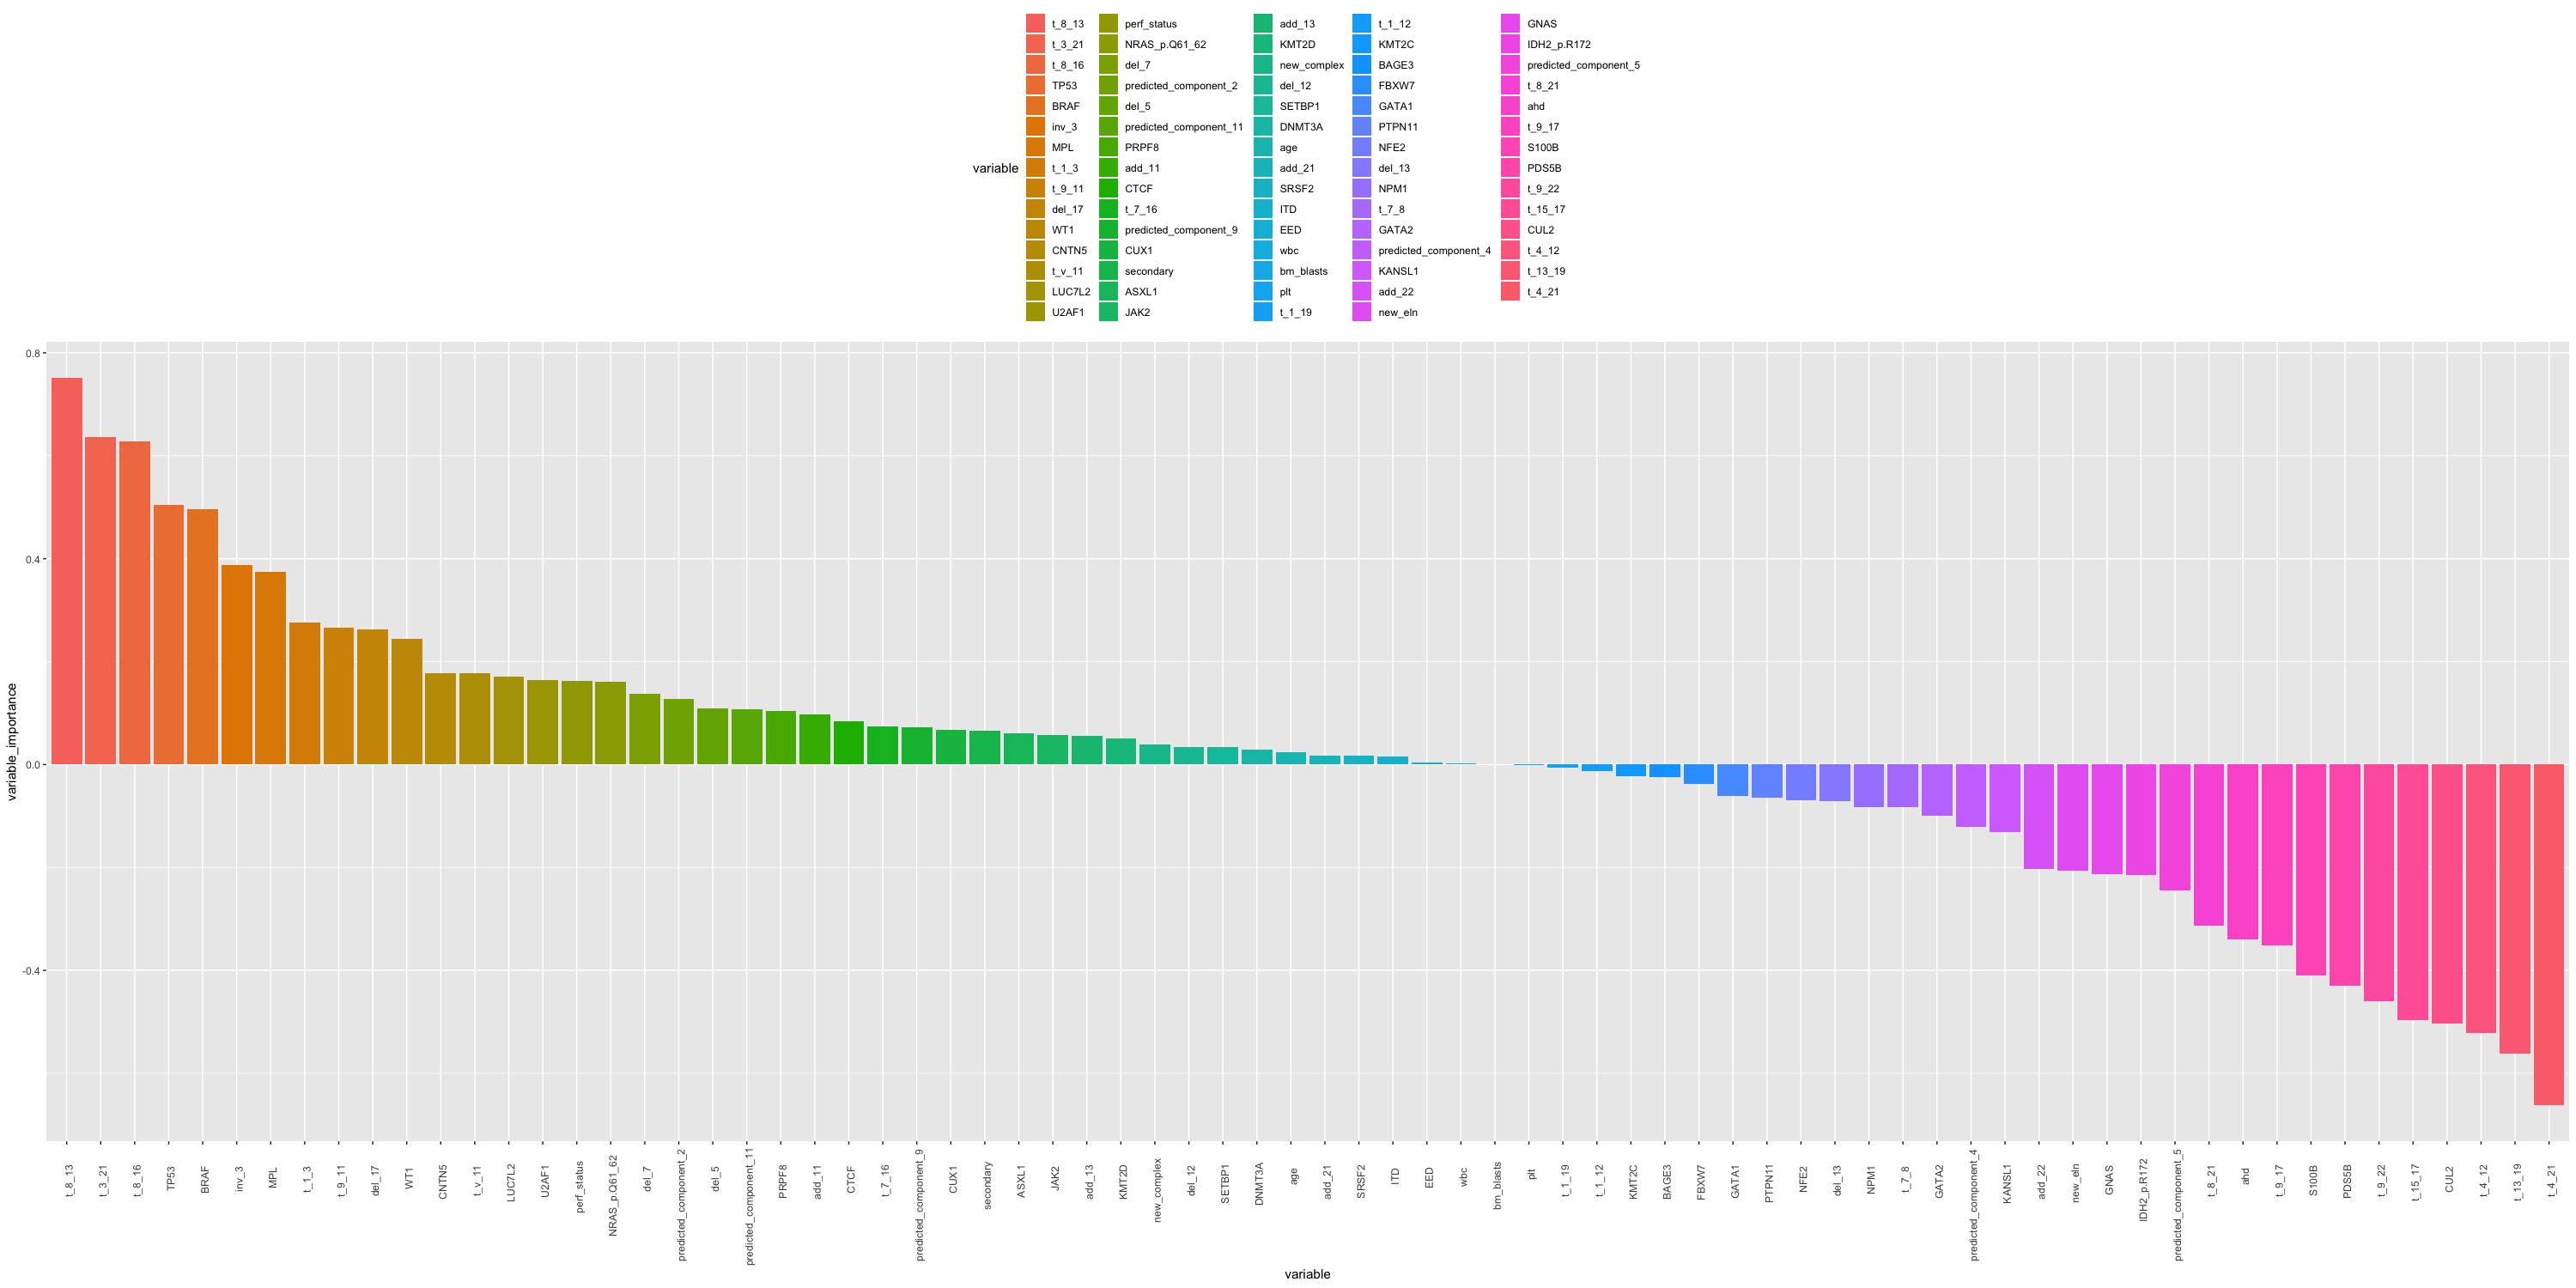

In [13]:
##Here, we look at the best concordance index that we got on testing set and we look at the coefficient that were obtained.
max_ci <-vector()
for (i in 1:length(rescv)){
    max_ci <- append(max_ci,rescv[[i]][[2]])
}

max = which(max_ci==max(max_ci))
l<- rescv[[max]][[1]]
l <- data.frame(l[l != 0,])
colnames(l) <- "variable_importance"
l$variable <-rownames(l)
l <- l[order(l$variable_importance,decreasing=T),]
l$variable <- factor(l$variable, levels = l$variable)

ggplot(l, aes(x=variable,y=variable_importance,fill=variable))+geom_bar(stat='identity')+
theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

# II- Random Forest Variable Importance

In [14]:
# Chose features you want with design
design=x[,all_features]
# Parallel CV
print("start CV")
rescv = mclapply(seq(nexp),
               FUN=function(iexp) {
                   set.seed(17)
                   cat(".")
                   vTrain = design[-folds[[iexp]],,drop=F]
                   vTest = design[folds[[iexp]],,drop=F]
                   lTrain = response[-folds[[iexp]],]
                   lTest = response[folds[[iexp]],]
                   # Train and Predict
                   #cvfit = cv.glmnet(vTrain, lTrain, family="cox", alpha=0.1, nfolds=10, grouped=TRUE)
                   cvfit = rfsrc(Surv(time, status) ~ ., data=data.frame(vTrain,lTrain), ntree=1500, importance="TRUE",nodesize=15)
    
                    # Predict
                   risk.predict = predict(cvfit, data.frame(vTest), importance="TRUE")$predicted
                   ci.test = suppressWarnings(survConcordance(Surv(time,status) ~ risk.predict, as.data.frame(lTest)))
                   # Evaluate CI on the test
                   #return(as.vector(coef(cvfit,s="lambda.min")))
                   #return (as.vector(ci.test$concordance))
                   return(list(as.matrix(cvfit$importance),as.vector(ci.test$concordance)))  ## return a list with dataframe for variable importance and concordance index of the exp
               },
               mc.cores=50
               )

[1] "start CV"


In [ ]:
### rescv returns a list with 25 dataframes with the coefficient of each variables for the model cross validated fitted model and 25 concordance indices on the testings set used . We do the boxplots of the variable
### importance to have an exhaustive view over the same algorithm trained differently.
tmp <- rescv[[1]][[1]]
colnames(tmp)[1] <- "exp_1"
for (i in 2:length(rescv)){
    tmp <-cbind(tmp,rescv[[i]][[1]])
    colnames(tmp)[i] <- paste("exp",i,sep="_")
}
tmp <-as.data.frame(tmp)
tmp$median <- apply(tmp,1, median, na.rm = TRUE)
tmp$features <-rownames(tmp)
b <-melt(tmp,id='features')
colnames(b) <- c('features','exp','value')
set_notebook_plot_size(30,15)
ggplot(b,aes(x=features,y=value)) +
    geom_boxplot(aes(fill = features), notch=F)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    #facet_wrap( ~ model, ncol=2) +
    #geom_hline(data = model_medians, aes(yintercept = Z), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

In [ ]:
##Here, we look at the best concordance index that we got on testing set and we look at the coefficient that were obtained.
set_notebook_plot_size(20,12)
max_ci <-vector()
for (i in 1:length(rescv)){
    max_ci <- append(max_ci,rescv[[i]][[2]])
}
max = which(max_ci==max(max_ci))
l<- rescv[[max]][[1]]
l <- data.frame(l[l != 0,])
colnames(l) <- "variable_importance"
l$variable <-rownames(l)
l <- l[order(l$variable_importance,decreasing=T),]
l$variable <- factor(l$variable, levels = l$variable)

ggplot(l, aes(x=variable,y=variable_importance,fill=variable))+geom_bar(stat='identity')+
theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

# III Boosting Feature Importance 

In [14]:
# Chose features you want with design
design=x[,all_features]
# Parallel CV
print("start CV")
rescv = mclapply(seq(nexp),
               FUN=function(iexp) {
                   set.seed(17)
                   cat(".")
                   vTrain = design[-folds[[iexp]],,drop=F]
                   vTest = design[folds[[iexp]],,drop=F]
                   lTrain = response[-folds[[iexp]],]
                   lTest = response[folds[[iexp]],]
                   # Train and Predict
                   #cvfit = cv.glmnet(vTrain, lTrain, family="cox", alpha=0.1, nfolds=10, grouped=TRUE)
                   #cvfit = rfsrc(Surv(time, status) ~ ., data=data.frame(vTrain,lTrain), ntree=1500, importance="TRUE",nodesize=15)
                   cvfit<-CoxBoost(time=lTrain[,1],status=lTrain[,2],x=vTrain)
                   risk.predict<-as.vector(predict(cvfit,vTest,newtime=lTest[,1],newstatus=lTest[,2],type='lp'))
                   ci.test = suppressWarnings(survConcordance(Surv(time,status) ~ risk.predict, as.data.frame(lTest)))
                   return(list(as.matrix(coefficients(cvfit)),as.vector(ci.test$concordance)))  ## return a list with dataframe for variable importance and concordance index of the exp
               },
               mc.cores=25
               )

[1] "start CV"


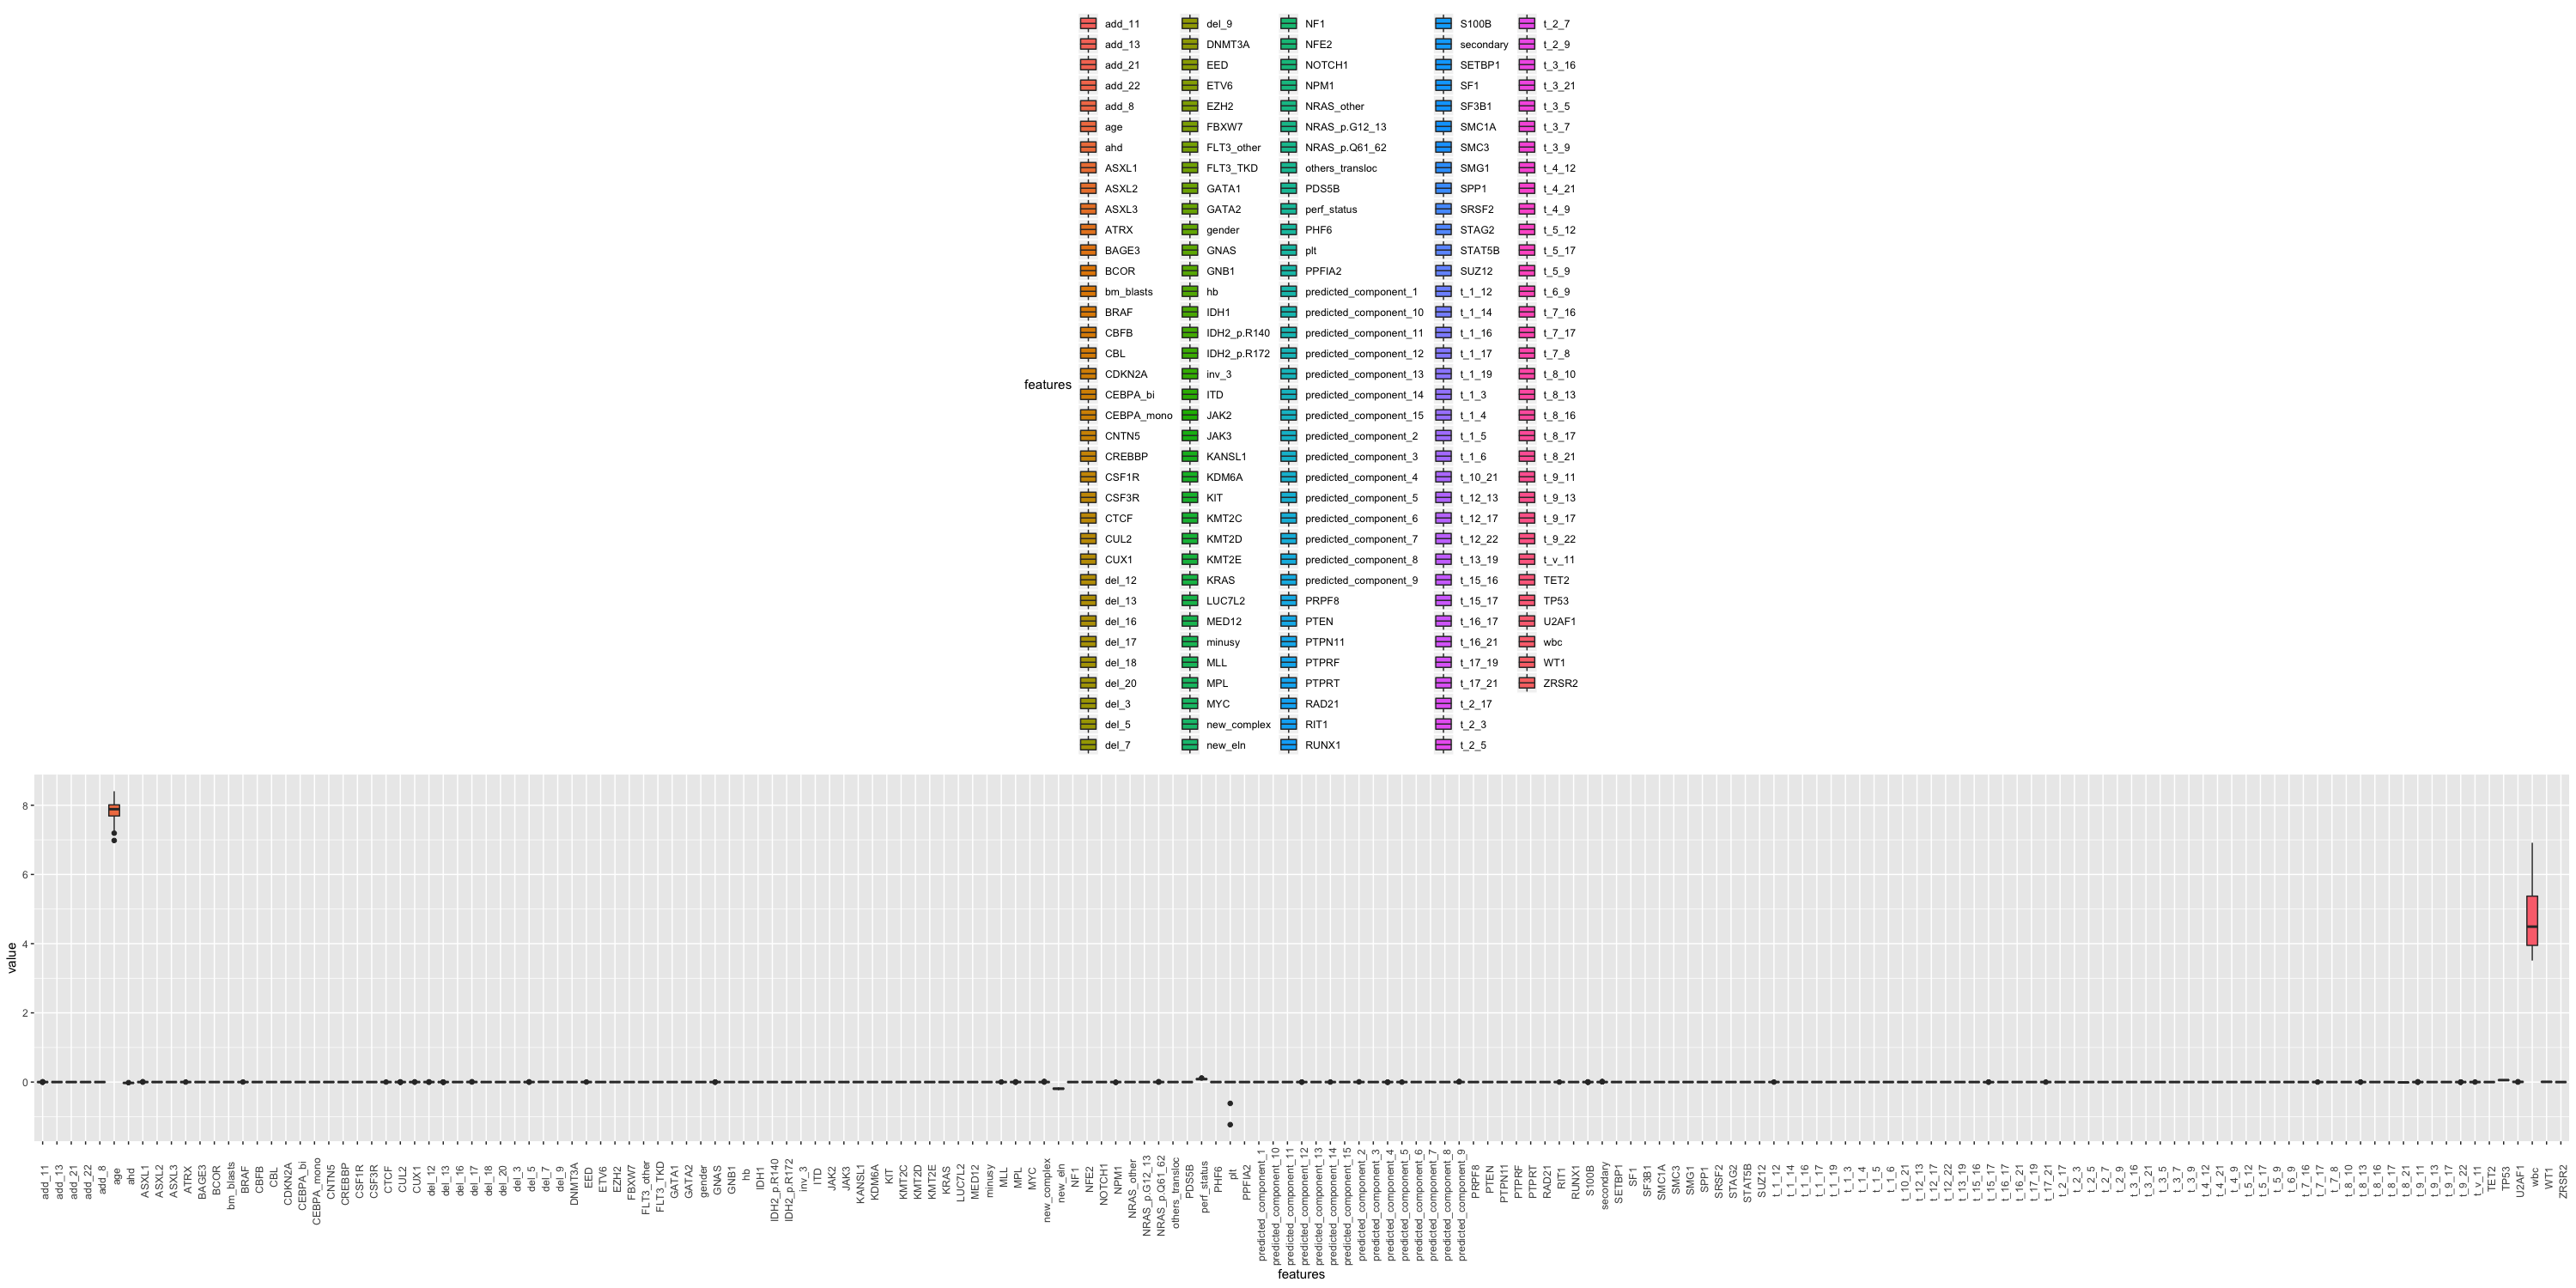

In [15]:
### rescv returns a list with 25 dataframes with the coefficient of each variables for the model cross validated fitted model and 25 concordance indices on the testings set used . We do the boxplots of the variable
### importance to have an exhaustive view over the same algorithm trained differently.
tmp <- rescv[[1]][[1]]
colnames(tmp)[1] <- "exp_1"
for (i in 2:length(rescv)){
    tmp <-cbind(tmp,rescv[[i]][[1]])
    colnames(tmp)[i] <- paste("exp",i,sep="_")
}
tmp <-as.data.frame(tmp)
tmp$median <- apply(tmp,1, median, na.rm = TRUE)
tmp$features <-rownames(tmp)
b <-melt(tmp,id='features')
colnames(b) <- c('features','exp','value')
set_notebook_plot_size(30,15)
ggplot(b,aes(x=features,y=value)) +
    geom_boxplot(aes(fill = features), notch=F)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    #facet_wrap( ~ model, ncol=2) +
    #geom_hline(data = model_medians, aes(yintercept = Z), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

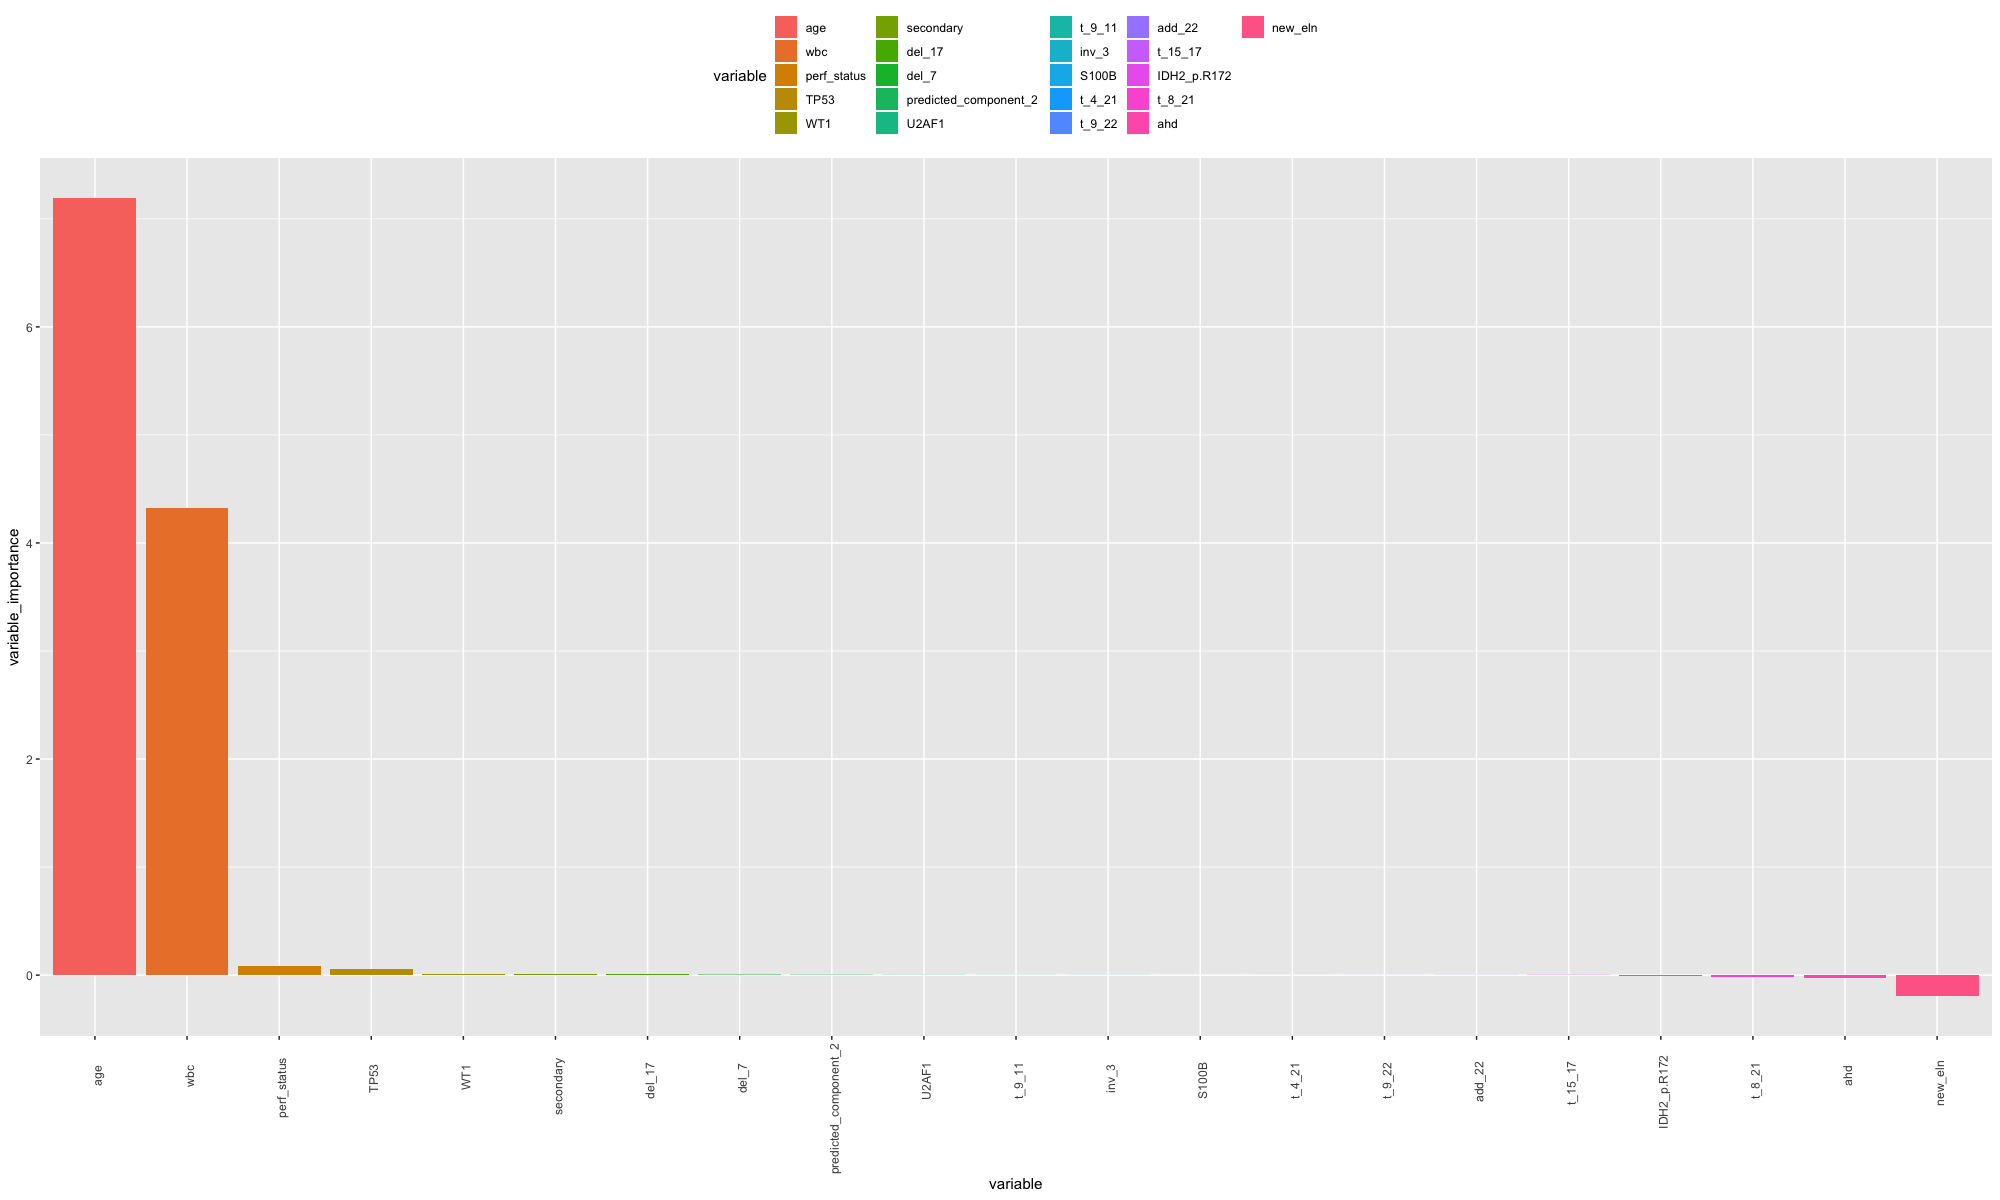

In [16]:
##Here, we look at the best concordance index that we got on testing set and we look at the coefficient that were obtained.
set_notebook_plot_size(20,12)
max_ci <-vector()
for (i in 1:length(rescv)){
    max_ci <- append(max_ci,rescv[[i]][[2]])
}
max = which(max_ci==max(max_ci))
l<- rescv[[max]][[1]]
l <- data.frame(l[l != 0,])
colnames(l) <- "variable_importance"
l$variable <-rownames(l)
l <- l[order(l$variable_importance,decreasing=T),]
l$variable <- factor(l$variable, levels = l$variable)

ggplot(l, aes(x=variable,y=variable_importance,fill=variable))+geom_bar(stat='identity')+
theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

# IV Random Effects

In [17]:
# Chose features you want with design
design=x[,all_features]
# Parallel CV
print("start CV")
rescv = mclapply(seq(nexp),
               FUN=function(iexp) {
                   set.seed(17)
                   cat(".")
                   vTrain = design[-folds[[iexp]],,drop=F]
                   vTest = design[folds[[iexp]],,drop=F]
                   lTrain = response[-folds[[iexp]],]
                   lTest = response[folds[[iexp]],]
                   # Train and Predict
                   #cvfit = cv.glmnet(vTrain, lTrain, family="cox", alpha=0.1, nfolds=10, grouped=TRUE)
                   #cvfit = rfsrc(Surv(time, status) ~ ., data=data.frame(vTrain,lTrain), ntree=1500, importance="TRUE",nodesize=15)
                   cvfit<-CoxRFX(data.frame(vTrain),Surv(time=lTrain[,1],event =lTrain[,2]) , max.iter =50,tol=1e-3)
                   cvfit$Z <- NULL
                   # Predict
                   risk.predict<-predict(cvfit,data.frame(vTest))
                   ci.test = suppressWarnings(survConcordance(Surv(time,status) ~ risk.predict, as.data.frame(lTest)))
                   return(list(as.matrix(coef(cvfit)),as.vector(ci.test$concordance)))  ## return a list with dataframe for variable importance and concordance index of the exp
               },
               mc.cores=25
               )

[1] "start CV"


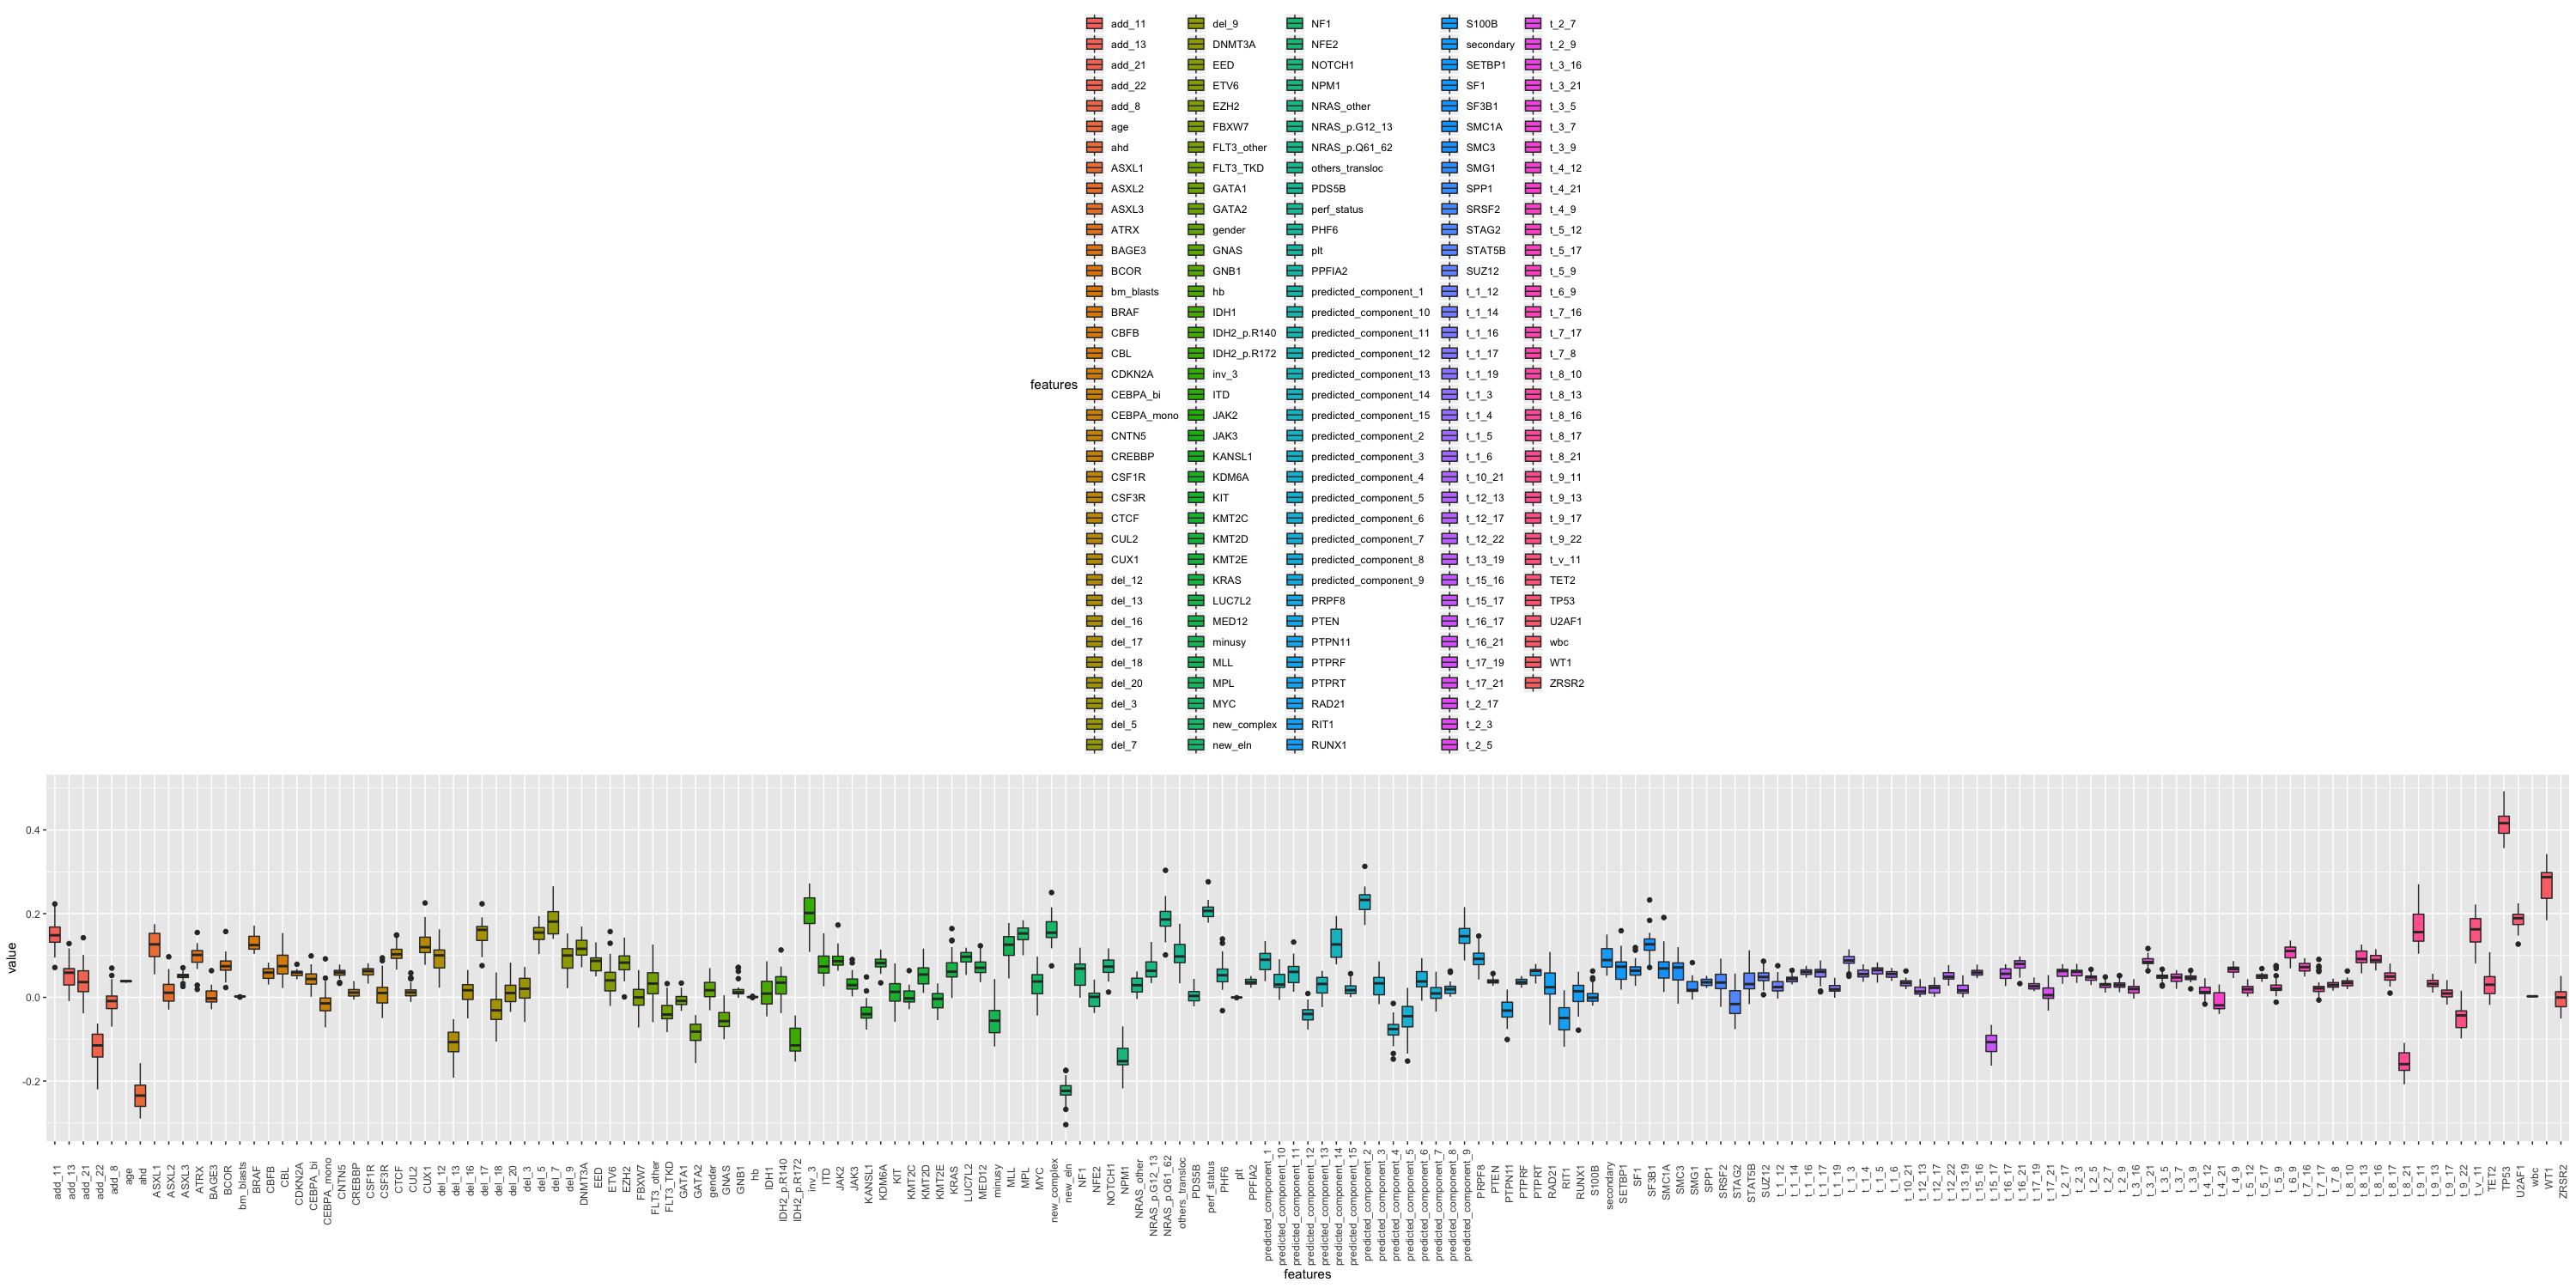

In [18]:
### rescv returns a list with 25 dataframes with the coefficient of each variables for the model cross validated fitted model and 25 concordance indices on the testings set used . We do the boxplots of the variable
### importance to have an exhaustive view over the same algorithm trained differently.
tmp <- rescv[[1]][[1]]
colnames(tmp)[1] <- "exp_1"
for (i in 2:length(rescv)){
    tmp <-cbind(tmp,rescv[[i]][[1]])
    colnames(tmp)[i] <- paste("exp",i,sep="_")
}
tmp <-as.data.frame(tmp)
tmp$median <- apply(tmp,1, median, na.rm = TRUE)
tmp$features <-rownames(tmp)
b <-melt(tmp,id='features')
colnames(b) <- c('features','exp','value')
set_notebook_plot_size(30,15)
ggplot(b,aes(x=features,y=value)) +
    geom_boxplot(aes(fill = features), notch=F)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    #facet_wrap( ~ model, ncol=2) +
    #geom_hline(data = model_medians, aes(yintercept = Z), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

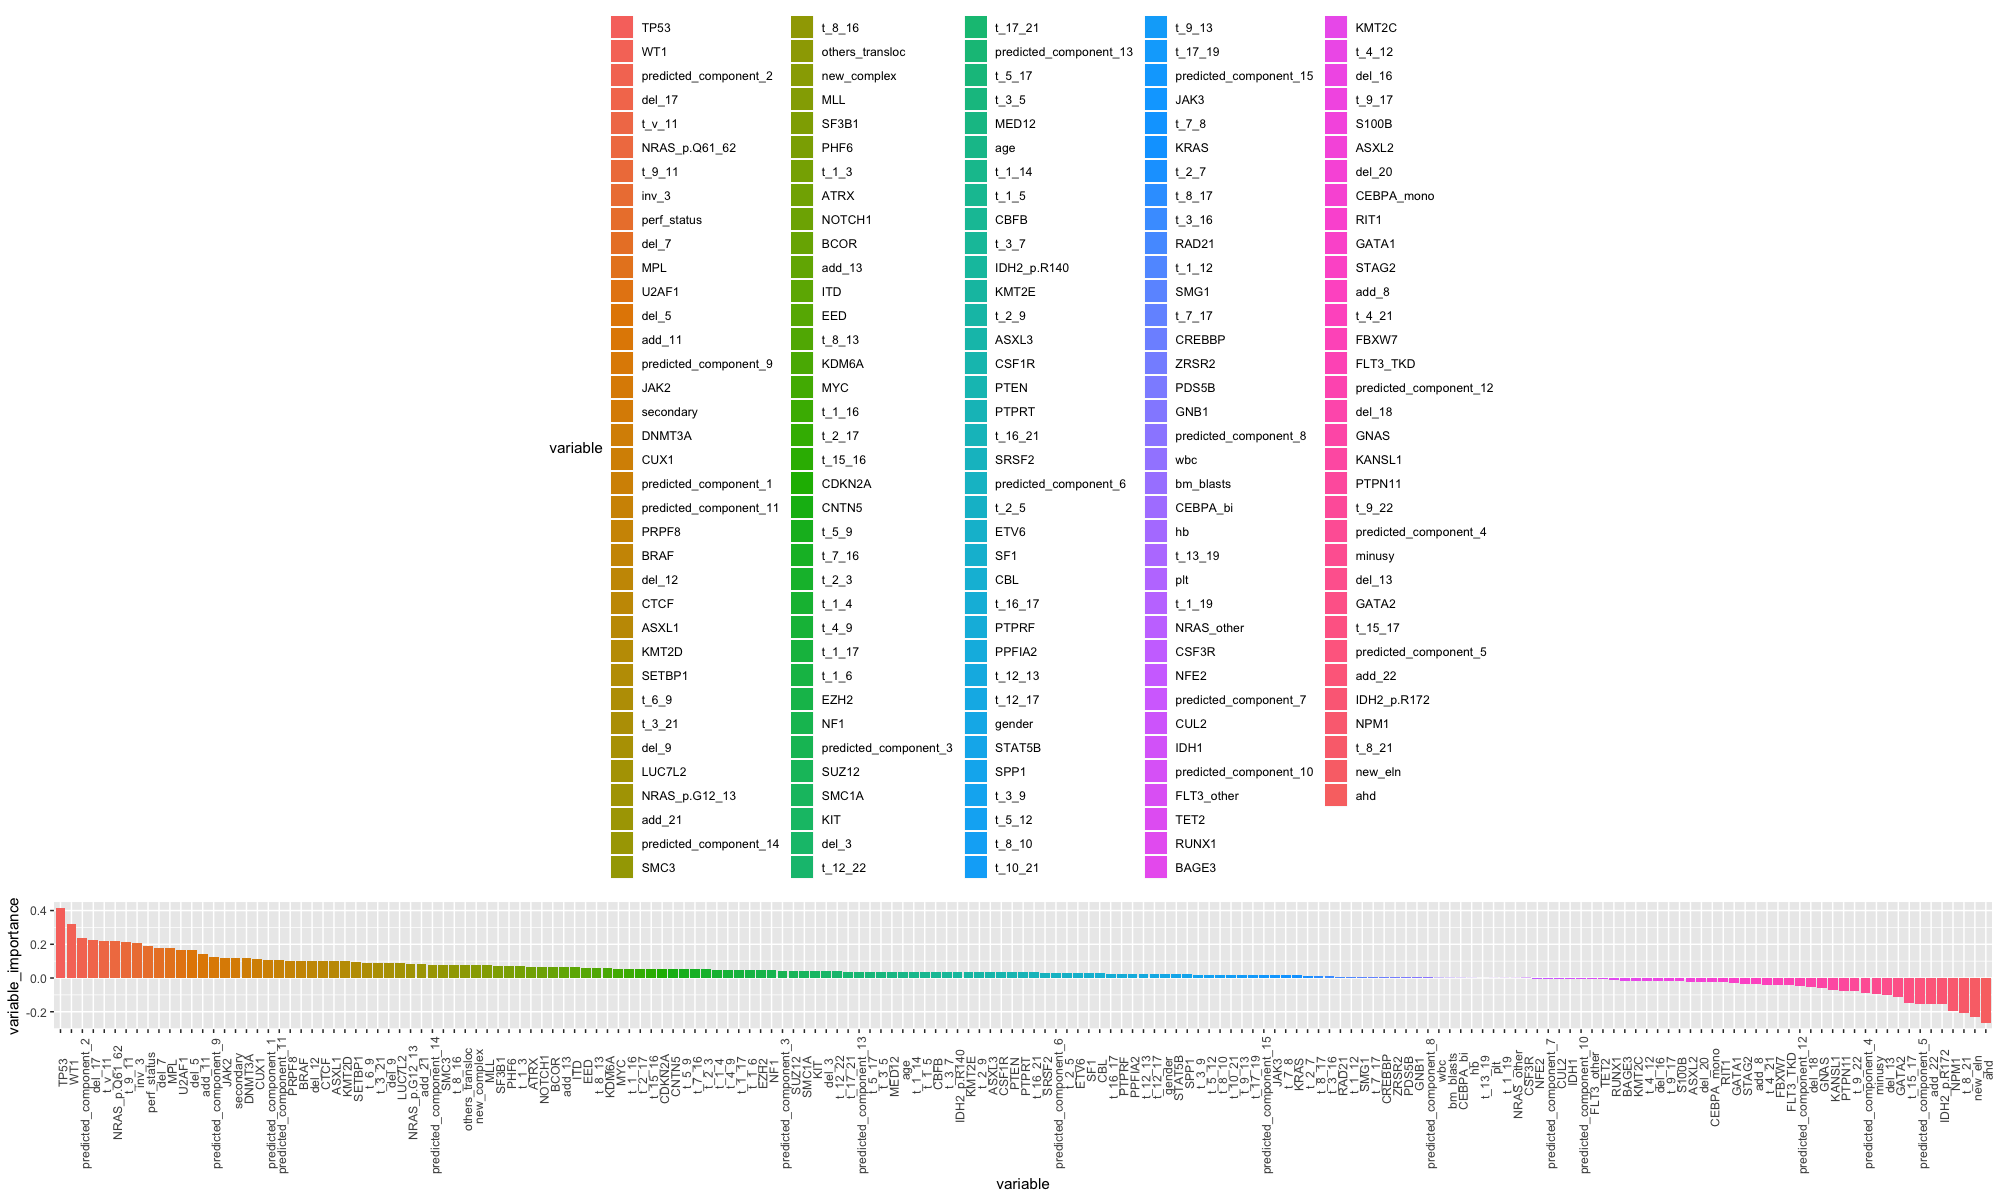

In [19]:
##Here, we look at the best concordance index that we got on testing set and we look at the coefficient that were obtained.
set_notebook_plot_size(20,12)
max_ci <-vector()
for (i in 1:length(rescv)){
    max_ci <- append(max_ci,rescv[[i]][[2]])
}
max = which(max_ci==max(max_ci))
l<- rescv[[max]][[1]]
l <- data.frame(l[l != 0,])
colnames(l) <- "variable_importance"
l$variable <-rownames(l)
l <- l[order(l$variable_importance,decreasing=T),]
l$variable <- factor(l$variable, levels = l$variable)

ggplot(l, aes(x=variable,y=variable_importance,fill=variable))+geom_bar(stat='identity')+
theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))